# Variants found in motifs important to PolyaClassifier site definition

**Purpose**: To quantify the enrichment or depletion of single nucleotide variants in significant motifs according to the *S. cerevisiae* PolyaClassifier model.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from tqdm import tqdm
tqdm.pandas()


In [5]:
species = 'saccharomyces_cerevisiae'
modeltype = 'polyaclassifier'
mt = 'polyaclassifier'
kmer = 6
config = 'polyaclassifier_bagging3_kmers-6'


In [6]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
DATADIR   = os.path.join(PROJECT, 'external_data', 'isolates2')
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyaclassifier_motif_importance_scer_variants')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [7]:
with open(os.path.join(RESOURCES, f'motif_definitions.scer.{kmer}mers.distance.pickle'), mode = 'rb') as handle:
    hamming_definitions = pickle.load(handle)

motif_h_priority = hamming_definitions['priority']
motif_h_family   = hamming_definitions['family']
motif_h_unique   = hamming_definitions['no_overlap']
motif_h_hamming  = hamming_definitions['hamming']


In [8]:
family_cmap = {
    'A-rich'        : '#2278b5',
    'T-rich'        : '#2fa148',
    'TA/TA-rich'    : '#d62a28',
}


In [9]:
with open(os.path.join(RESOURCES, 'polyaclassifier_motifs.family_profiles.pickle'), mode = 'rb') as handle:
    mfam_importance = pickle.load(handle)
    
mfam_importance = mfam_importance[species][modeltype][config]


In [10]:
with open(os.path.join(RESOURCES, 'polyaclassifier_motifs.significant_motifs.pickle'), mode = 'rb') as handle:
    significant_motifs = pickle.load(handle)

sigmots = significant_motifs[species][modeltype][config]
print(f"Significant motifs: {len(sigmots)}")


Significant motifs: 137


In [11]:
for mf,ml in motif_h_priority.items():
    if ('_d' in mf):
        print(f"{mf:13}:\tmotifs={len(ml):4}\tsig={sum([(m in sigmots) for m in ml]):3} ({sum([(m in sigmots) for m in ml])/len(ml):>7.02%})")
    

A-rich_d0    :	motifs=   1	sig=  1 (100.00%)
A-rich_d1    :	motifs=  18	sig= 12 ( 66.67%)
A-rich_d2    :	motifs= 117	sig= 18 ( 15.38%)
T-rich_d0    :	motifs=   1	sig=  1 (100.00%)
T-rich_d1    :	motifs=  18	sig= 18 (100.00%)
T-rich_d2    :	motifs= 117	sig= 32 ( 27.35%)
TA/TA-rich_d0:	motifs=   2	sig=  2 (100.00%)
TA/TA-rich_d1:	motifs=  36	sig= 29 ( 80.56%)
TA/TA-rich_d2:	motifs= 234	sig=  9 (  3.85%)


## HELPER FUNCTIONS

In [12]:
def calculate_pa_distance(row, strand_prefix, pos_prefix):
    
    if (row[f'{strand_prefix}_strand'] == '+'):
        pos_index = row[f'{pos_prefix}_start'] - row['pa_window_start']
        
    elif (row[f'{strand_prefix}_strand'] == '-'):
        pos_index = row['pa_window_end'] - row[f'{pos_prefix}_end']
    
    return pos_index - int((row['pa_window_end'] - row['pa_window_start'])/2)


## ANALYSIS

### Identify significant motifs surrounding polyA sites

In [13]:
## Assign motifs to polyA sites

motifs_input = pd.read_csv(os.path.join(DATADIR, 'enrichment_analysis.gold_top1_window_overlap_with_motifs.txt'), sep = '\t',
                           names = ['pa_chrom', 'pa_window_start', 'pa_window_end', 'pa_label', 'pa_reads', 'pa_strand',
                           'motif_chrom', 'motif_start', 'motif_end', 'motif_label', 'motif_score', 'motif_strand']
                          )


## Remove sites where no motifs overlap

motifs = motifs_input.loc[(motifs_input['motif_chrom'] != '.') & (motifs_input['motif_start'] != -1)].copy()


## Process motif labels and information

motifs['motif_id']           = motifs['motif_chrom'] + ":" + motifs['motif_start'].astype(str) + ":" + motifs['motif_strand']
motifs['motif']              = motifs['motif_label'].str.split("|").str[0]
motifs['motif_family']       = motifs['motif'].apply(lambda x : motif_h_family.get(x,'Other'))
motifs['motif_hamming']      = motifs['motif'].apply(lambda x : motif_h_hamming.get(x,'Other'))
motifs['motif_significance'] = motifs['motif'].isin(sigmots)


## Process associated polyA site labels and information

motifs['pa_id']              = motifs['pa_label'].str.split("|").str[0]
motifs['pa_start']           = motifs['pa_id'].str.split(":").str[1].astype(float).astype(int)


## Calculate the relative position of the motif around the polyA site

motifs['pa_distance']        = motifs.progress_apply(lambda row: calculate_pa_distance(row, 'motif', 'motif'), axis = 1)


print(f"PolyA-motif overlap: input={motifs_input.shape}, overlapping={motifs.shape}")


100%|██████████| 5300094/5300094 [04:05<00:00, 21585.57it/s]

PolyA-motif overlap: input=(5300094, 12), overlapping=(5300094, 20)


In [14]:
## Map polyA sites --> genomic positions covered by motifs from family f
## This will be used to identify variants that overlap significant motifs

pa_motif_positions = {}

for family in ['TA/TA-rich','A-rich','T-rich']:
    
    pa_motif_positions[family] = {}
    
    fmotifs = motifs.loc[motifs['motif_family'] == family]
    
    for fmpaid,fmstart,fmend in tqdm(zip(fmotifs['pa_id'], fmotifs['motif_start'], fmotifs['motif_end']), total = len(fmotifs), desc = f'{family:10}'):
        
        if (fmpaid not in pa_motif_positions[family]):
            pa_motif_positions[family][fmpaid] = {}
        
        for fmpos in range(fmstart,fmend):
            pa_motif_positions[family][fmpaid][fmpos] = 1
    

T-rich    : 100%|██████████| 2375037/2375037 [00:04<00:00, 503326.25it/s]


### Identify variants surrounding polyA sites

In [15]:
## Assign variants to polyA sites

variants_input = pd.read_csv(os.path.join(DATADIR, 'enrichment_analysis.gold_top1_window_overlap_with_snvs.txt'), sep = "\t",
                         names = ['pa_chrom', 'pa_window_start', 'pa_window_end', 'pa_label', 'pa_reads', 'pa_strand', 
                                  'var_chrom', 'var_start', 'var_end', 'var_qual', 'var_ref', 'var_alt'])


## Remove sites where no variants overlap

variants = variants_input.loc[(variants_input['var_chrom'] != '.') & (variants_input['var_start'] != -1)].copy()


## Process variant and polyA site labels

variants['var_id']      = variants['var_chrom'] + ":" + variants['var_start'].astype(str) + ":" + variants['var_ref'] + ":" + variants['var_alt']
variants['pa_id']       = variants['pa_label'].str.split("|").str[0]


## Calculate the relative position of the variant around the polyA site

variants['pa_distance'] = variants.progress_apply(lambda row : calculate_pa_distance(row, 'pa', 'var'), axis = 1)


print(f"PolyA-variant overlap: input={variants_input.shape}, overlapping={variants.shape}")


/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 8105891/8105891 [06:15<00:00, 21595.13it/s]

PolyA-variant overlap: input=(8105892, 12), overlapping=(8105891, 15)


In [16]:
## Flag variants that overlap significant motifs

variants['overlap_TA/TA-rich'] = variants.progress_apply(lambda row : pa_motif_positions['TA/TA-rich'].get(row['pa_id'],{}).get(row['var_start'],0), axis = 1)
variants['overlap_A-rich'    ] = variants.progress_apply(lambda row : pa_motif_positions['A-rich'    ].get(row['pa_id'],{}).get(row['var_start'],0), axis = 1)
variants['overlap_T-rich'    ] = variants.progress_apply(lambda row : pa_motif_positions['T-rich'    ].get(row['pa_id'],{}).get(row['var_start'],0), axis = 1)

print(f"Overlap with TA/TA-rich? {variants['overlap_TA/TA-rich'].value_counts(sort = False).to_dict()}")
print(f"Overlap with A-rich?     {variants['overlap_A-rich'    ].value_counts(sort = False).to_dict()}")
print(f"Overlap with T-rich?     {variants['overlap_T-rich'    ].value_counts(sort = False).to_dict()}")


100%|██████████| 8105891/8105891 [02:50<00:00, 47580.60it/s]


Overlap with TA/TA-rich? {0: 7531008, 1: 574883}
Overlap with A-rich?     {0: 7432977, 1: 672914}
Overlap with T-rich?     {0: 7222797, 1: 883094}


### Enrichment of variants in significant motifs around polyA sites

We calculate the enrichment of variants overlapping significant motifs using an odds ratio approach:

$E_{f,x} = log_2 \left( \left( \frac{O_{f,x}}{N_{f,x}} \right) / \left( \frac{V_f}{M_f} \right) \right)$

We need to calculate 4 quantities:

`nfx` = coverage of motifs from family f at position x, which can be calculated from the number of motifs that cross position x

`mf` = coverage of motifs from family f in background region, which is the number of motifs in the background region multiplied by the length of the motifs (6 nt)

`ofx` = count of variants that overlap motifs from family f at each position x and multiply by 6 (length of the motifs) to calculate the overall motif coverage

`vf` = count of variants that overlap motifs from family f in background region


In [17]:
def calculate_motif_variant_enrichment(mdata, vdata, family, window):
    
    xs = np.arange(-1*int(window/2), int(window/2), 1)
    
    
    ##############
    # MOTIF DATA #
    ##############
    
    ## Filter motif data for family f within the background boundaries
    fdata = mdata.loc[(mdata['motif_family'] == family) & (mdata['pa_distance'].between(-1*int(window/2), int(window/2)-1))]
    
    ## Count motifs from family f present in background region
    mf = fdata.shape[0] * 6
    
    ## Count motifs that cross each position
    nfx = dict(zip(xs, [fdata.loc[fdata['pa_distance'].between(x-5,x)].shape[0] for x in xs]))

    
    ################
    # VARIANT DATA #
    ################
    
    ## Filter variant data overlapping family f and within the background boundaries
    vdata = variants.loc[(variants[f'overlap_{family}'] > 0) & (variants['pa_distance'].between(-1*int(window/2), int(window/2)-1))]
    
    ## Count variants overlapping family f present in background region
    vf = vdata.shape[0]
    
    ## Count variants overlapping family f at each position
    ofx = vdata.groupby('pa_distance').size().to_dict()
    
    
    ###################
    # CALCULATE RATIO #
    ###################
    
    rx = pd.Series(
        data = np.asarray([np.log2((ofx.get(x,0) / nfx.get(x,0)) / (vf/mf)) for x in xs]),
        index = xs
    )
    
    return rx


### Explore the effect of different background region sizes

500
Raw data plot range: -0.6136020289988653 0.9575391107587793
Smooth data plot range: -0.44433863848456034 0.5505599043313404


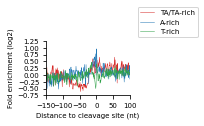

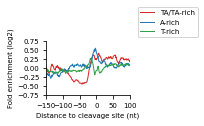

1000
Raw data plot range: -0.6408848000208194 1.0162840297662197
Smooth data plot range: -0.47162140950651465 0.60930482333878


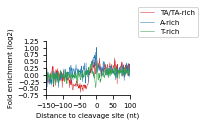

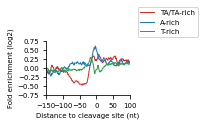

2000
Raw data plot range: -0.6589684656227761 1.0350897116743512
Smooth data plot range: -0.4897050751084716 0.6281105052469127


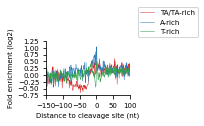

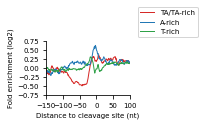

5000
Raw data plot range: -0.6916432873001616 1.0291287962131068
Smooth data plot range: -0.5223798967858568 0.6221495897856675


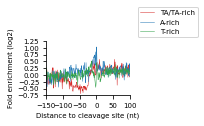

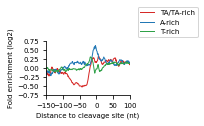

10000
Raw data plot range: -0.6989971294512181 1.02026967935169
Smooth data plot range: -0.5297337389369134 0.6132904729242503


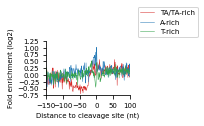

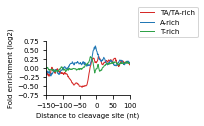

In [18]:
for window in [500,1000,2000,5000,10000]:
    print(window)

    ratios_ta = calculate_motif_variant_enrichment(motifs, variants, 'TA/TA-rich', window)
    ratios_a  = calculate_motif_variant_enrichment(motifs, variants, 'A-rich',     window)
    ratios_t  = calculate_motif_variant_enrichment(motifs, variants, 'T-rich',     window)
    
    print("Raw data plot range:", 
          min([ratios_ta[list(range(-150,100))].min(), ratios_a[list(range(-150,100))].min(), ratios_t[list(range(-150,100))].min()]),
          max([ratios_ta[list(range(-150,100))].max(), ratios_a[list(range(-150,100))].max(), ratios_t[list(range(-150,100))].max()])
         )

    smooth_ta = pd.Series(ratios_ta).rolling(window = 10, center = True).mean()
    smooth_a  = pd.Series(ratios_a ).rolling(window = 10, center = True).mean()
    smooth_t  = pd.Series(ratios_t ).rolling(window = 10, center = True).mean()
    
    print("Smooth data plot range:", 
          min([smooth_ta[list(range(-150,100))].min(), smooth_a[list(range(-150,100))].min(), smooth_t[list(range(-150,100))].min()]),
          max([smooth_ta[list(range(-150,100))].max(), smooth_a[list(range(-150,100))].max(), smooth_t[list(range(-150,100))].max()])
         )
    

    ## Calculate normalized enrichment ratios

    fig,ax = plt.subplots(1,1, figsize = (1.5,1))

    sns.lineplot(x = ratios_ta.index, y = ratios_ta, label = 'TA/TA-rich', color = family_cmap['TA/TA-rich'], linewidth = 0.5, ax = ax)
    sns.lineplot(x = ratios_a.index,  y = ratios_a,  label = 'A-rich',     color = family_cmap['A-rich'],     linewidth = 0.5, ax = ax)
    sns.lineplot(x = ratios_t.index,  y = ratios_t,  label = 'T-rich',     color = family_cmap['T-rich'],     linewidth = 0.5, ax = ax)

    ax.set_xlabel("Distance to cleavage site (nt)")
    ax.set_ylabel("Fold enrichment (log2)")

    ax.set_xlim(-150,100)
    ax.xaxis.set_major_locator(MultipleLocator(50))

    ax.set_ylim(-0.75,1.25)
    ax.yaxis.set_major_locator(MultipleLocator(0.25))

    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'variant_enrichment_analysis.background_window_{window}.raw.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


    ## Calculate normalized enrichment ratios

    fig,ax = plt.subplots(1,1, figsize = (1.5,1))

    sns.lineplot(x = smooth_ta.index, y = smooth_ta, label = 'TA/TA-rich', color = family_cmap['TA/TA-rich'], linewidth = 1, ax = ax)
    sns.lineplot(x = smooth_a.index,  y = smooth_a,  label = 'A-rich',     color = family_cmap['A-rich'],     linewidth = 1, ax = ax)
    sns.lineplot(x = smooth_t.index,  y = smooth_t,  label = 'T-rich',     color = family_cmap['T-rich'],     linewidth = 1, ax = ax)

    ax.set_xlabel("Distance to cleavage site (nt)")
    ax.set_ylabel("Fold enrichment (log2)")

    ax.set_xlim(-150,100)
    ax.xaxis.set_major_locator(MultipleLocator(50))

    ax.set_ylim(-0.75,0.75)
    ax.yaxis.set_major_locator(MultipleLocator(0.25))

    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'variant_enrichment_analysis.background_window_{window}.smooth.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


### Observe the effect of different background region sizes

In [19]:
window = 2000

ratios_ta = calculate_motif_variant_enrichment(motifs, variants, 'TA/TA-rich', window)
ratios_a  = calculate_motif_variant_enrichment(motifs, variants, 'A-rich',     window)
ratios_t  = calculate_motif_variant_enrichment(motifs, variants, 'T-rich',     window)

print("Raw data plot range:", 
          min([ratios_ta[list(range(-150,100))].min(), ratios_a[list(range(-150,100))].min(), ratios_t[list(range(-150,100))].min()]),
          max([ratios_ta[list(range(-150,100))].max(), ratios_a[list(range(-150,100))].max(), ratios_t[list(range(-150,100))].max()])
         )

Raw data plot range: -0.6589684656227761 1.0350897116743512


In [20]:
smooth_ta = pd.Series(ratios_ta).rolling(window = 10, center = True).mean()
smooth_a  = pd.Series(ratios_a ).rolling(window = 10, center = True).mean()
smooth_t  = pd.Series(ratios_t ).rolling(window = 10, center = True).mean()

print("Smooth data plot range:", 
          min([smooth_ta[list(range(-150,100))].min(), smooth_a[list(range(-150,100))].min(), smooth_t[list(range(-150,100))].min()]),
          max([smooth_ta[list(range(-150,100))].max(), smooth_a[list(range(-150,100))].max(), smooth_t[list(range(-150,100))].max()])
         )

Smooth data plot range: -0.4897050751084716 0.6281105052469127


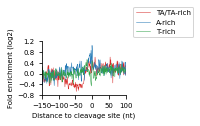

In [21]:
## Calculate normalized enrichment ratios

fig,ax = plt.subplots(1,1, figsize = (1.5,1))

sns.lineplot(x = ratios_ta.index, y = ratios_ta, label = 'TA/TA-rich', color = family_cmap['TA/TA-rich'], linewidth = 0.5, ax = ax)
sns.lineplot(x = ratios_a.index,  y = ratios_a,  label = 'A-rich',     color = family_cmap['A-rich'],     linewidth = 0.5, ax = ax)
sns.lineplot(x = ratios_t.index,  y = ratios_t,  label = 'T-rich',     color = family_cmap['T-rich'],     linewidth = 0.5, ax = ax)

ax.set_xlabel("Distance to cleavage site (nt)")
ax.set_ylabel("Fold enrichment (log2)")

ax.set_xlim(-150,100)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylim(-0.8,1.2)
ax.yaxis.set_major_locator(MultipleLocator(0.4))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'variant_enrichment_analysis.background_window_{window}.raw.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


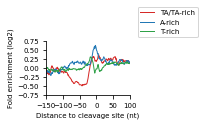

In [22]:
## Calculate normalized enrichment ratios

fig,ax = plt.subplots(1,1, figsize = (1.5,1))

sns.lineplot(x = smooth_ta.index, y = smooth_ta, label = 'TA/TA-rich', color = family_cmap['TA/TA-rich'], linewidth = 1, ax = ax)
sns.lineplot(x = smooth_a.index,  y = smooth_a,  label = 'A-rich',     color = family_cmap['A-rich'],     linewidth = 1, ax = ax)
sns.lineplot(x = smooth_t.index,  y = smooth_t,  label = 'T-rich',     color = family_cmap['T-rich'],     linewidth = 1, ax = ax)

ax.set_xlabel("Distance to cleavage site (nt)")
ax.set_ylabel("Fold enrichment (log2)")

ax.set_xlim(-150,100)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylim(-0.75,0.75)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'variant_enrichment_analysis.background_window_{window}.smooth.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Determine statistical significance in key regions

In [23]:
def statistics_motif_variant_enrichment(mdata, vdata, family, window, region):
    
    
    ##############
    # MOTIF DATA #
    ##############
    
    ## Filter motif data for family f within the background boundaries
    fdata = mdata.loc[(mdata['motif_family'] == family) & (mdata['pa_distance'].between(-1*int(window/2), int(window/2)-1))].copy()
    
    ## Assign data to region of interest
    fdata['region'] = fdata['pa_distance'].between(*region)
    
    ## Calculate motif coverage inside and outisde of region
    fcov = fdata.groupby('region').size() * 6

    
    ################
    # VARIANT DATA #
    ################
    
    ## Filter variant data overlapping family f and within the background boundaries
    vdata = variants.loc[(variants[f'overlap_{family}'] > 0) & (variants['pa_distance'].between(-1*int(window/2), int(window/2)-1))].copy()
    
    ## Assign data to region of interest
    vdata['region'] = vdata['pa_distance'].between(*region)
    
    ## Calculate variants inside and outisde of region
    vcov = vdata.groupby('region').size()
    
    
    ####################
    # STATISTICAL TEST #
    ####################
    
    # Set up the contingency table and calculate the Chi2 contingency test p-value

    table = np.asarray([
        [vcov.loc[True], vcov.loc[False]],
        [fcov.loc[True], fcov.loc[False]]
    ])
    
    print(f"{family}\n\n        Region:  Within  Outside")
    print(f"Variant counts: {table[0][0]:7} {table[0][1]:8}")
    print(f"Motif coverage: {table[1][0]:7} {table[1][1]:8}")
    
    stat, pval, _, _ = st.chi2_contingency(table)
    print(f"\nChi2 contingency test: statistic={stat:.02f}, pval={pval:.02E}")
    
    return


In [24]:
statistics_motif_variant_enrichment(motifs, variants, 'TA/TA-rich', window, (-90,-25))

TA/TA-rich

        Region:  Within  Outside
Variant counts:   14368   106896
Motif coverage:  249468  1324434

Chi2 contingency test: statistic=1371.68, pval=2.99E-300


In [25]:
statistics_motif_variant_enrichment(motifs, variants, 'A-rich', window, (-25,-15))

A-rich

        Region:  Within  Outside
Variant counts:    1861   139947
Motif coverage:   27306  2162322

Chi2 contingency test: statistic=4.54, pval=3.31E-02


In [26]:
statistics_motif_variant_enrichment(motifs, variants, 'T-rich', window, (-15,15))

T-rich

        Region:  Within  Outside
Variant counts:    7793   166393
Motif coverage:  132396  2668236

Chi2 contingency test: statistic=23.39, pval=1.32E-06
